# Highly Imbalanced Fraud Data 의 분류
## DNN 이용, Class Weight 조정, OverSampling
## ROC 비교

- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle


- 클래스 불균형 비율이 주어지면 Area Under the Precision-Recall Curve (AUPRC)을 사용하여 정확도를 측정하는 것이 좋습니다. 불균형 data 분류에는 confusion matrix 정확도가 의미가 없습니다.

In [29]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, \
                            roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)

### Download the Kaggle Credit Card Fraud data set

- [kaggle creditcard csv file](https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv)

In [4]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
# df = pd.read_csv('data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 클래스 레이블 불균형 조사

In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [30]:
neg, pos = np.bincount(df['Class'])
print(neg, pos)

total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n' \
       .format(total, pos, 100 * pos / total))

284315 492
Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### Clean, split and normalize the data

In [31]:
cleaned_df = df.copy()

# Time 을 일중 시간으로 변환
cleaned_df.loc[:, "Time"] = cleaned_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) 

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001      # 0 => 0.1¢
cleaned_df['Amount'] = np.log(cleaned_df.pop('Amount') + eps)

cleaned_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


In [32]:
cleaned_df['Amount'].describe()

count    284807.000000
mean          2.942089
std           2.023685
min          -6.907755
25%           1.722945
50%           3.091088
75%           4.345959
max          10.153902
Name: Amount, dtype: float64

In [33]:
labels = np.array(cleaned_df.pop('Class'))
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [34]:
features = cleaned_df.values
features.shape

(284807, 30)

<AxesSubplot:ylabel='count'>

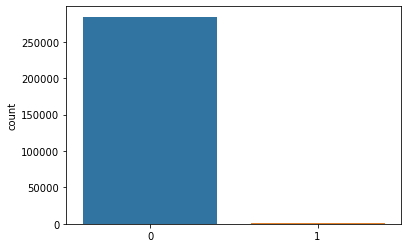

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(x=labels)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 30), (56962, 30), (227845,), (56962,))

## Feature Scaling

In [39]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### Metrics

In [41]:
METRICS = tf.keras.metrics.AUC(name='auc')

## Simple NN model 정의 - 이진 분류 모델

In [48]:
def make_model():
    
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu', 
                            input_shape=(X_train.shape[-1],)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

    model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss = 'binary_crossentropy', metrics=[METRICS, 'accuracy'])

    return model

### Baseline model build

In [49]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10, # no of epochs of no improvement          
    mode='max',  #val_auc 가 10 번 연속 증가 안하면 stop           
    restore_best_weights=True)  # epoch 의 best weight 저장

In [50]:
model = make_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                992       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [51]:
model = make_model()
baseline_history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(X_test, y_test))

Epoch 1/100
112/112 [==============================] - 1s 3ms/step - loss: 0.2567 - auc: 0.4455 - accuracy: 0.9289 - val_loss: 0.0392 - val_auc: 0.2483 - val_accuracy: 0.9982
Epoch 2/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0331 - auc: 0.6586 - accuracy: 0.9984 - val_loss: 0.0078 - val_auc: 0.8984 - val_accuracy: 0.9991
Epoch 3/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0142 - auc: 0.8527 - accuracy: 0.9988 - val_loss: 0.0049 - val_auc: 0.9167 - val_accuracy: 0.9992
Epoch 4/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0099 - auc: 0.8792 - accuracy: 0.9989 - val_loss: 0.0041 - val_auc: 0.9148 - val_accuracy: 0.9993
Epoch 5/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0077 - auc: 0.9022 - accuracy: 0.9990 - val_loss: 0.0037 - val_auc: 0.9153 - val_accuracy: 0.9993
Epoch 6/100
112/112 [==============================] - 0s 2ms/step - loss: 0.0065 - auc: 0.9217 - accuracy: 0.9991 - val_loss

In [53]:
baseline_history.history['val_accuracy'][-1]

0.9994557499885559

## Evaluate Metric

- confusion matrix 를 이용하여 metrics 요약

In [54]:
predictions_baseline  = model.predict(X_test, batch_size=BATCH_SIZE)
predictions_baseline.shape

(56962, 1)

In [55]:
def plot_cm(labels, pred_proba, threshold=0.5):
    
    y_predict = pred_proba > threshold
    
    cm = confusion_matrix(y_test, y_predict)
    
    print("confution matrix\n", cm)
    print()
    print("f1 score\n", f1_score(y_test, y_predict))
    print()
    print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_predict)))
    print("Precision: {:.5f}".format(precision_score(y_test, y_predict)))
    print("Recall: {:.5f}".format(recall_score(y_test, y_predict)))
    
    plt.figure(figsize=(5,5))

    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @>{:.2f} '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

### Test dataset 으로 evaluate 하고, confusion matrix 를 그린다

confution matrix
 [[56849    12]
 [   22    79]]

f1 score
 0.8229166666666666

Accuracy: 0.99940
Precision: 0.86813
Recall: 0.78218


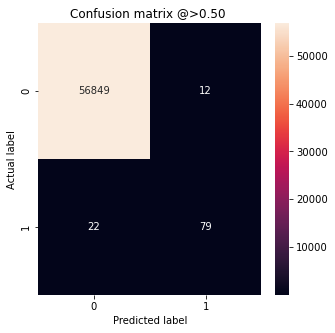

In [56]:
plot_cm(y_test, predictions_baseline, threshold=0.5)

## Plot ROC

In [57]:
def plot_roc(name, labels, predictions, **kwargs):
    
    fp, tp, _ = roc_curve(labels, predictions)
    auc = roc_auc_score(y_test, predictions)
    
    plt.plot(100*fp, 100*tp, label=f"auc of {name}={auc:.5f}", linewidth=2, **kwargs)
    plt.xlabel('FP [%]')
    plt.ylabel('TP [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    fig = plt.gcf()
    fig.set_size_inches(8, 6)

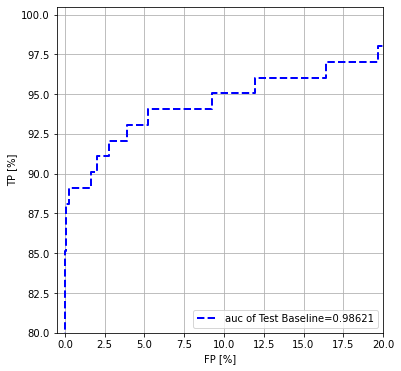

In [58]:
plot_roc("Test Baseline", y_test, predictions_baseline, color='blue', linestyle='--')
plt.legend(loc='lower right')

정밀도가 비교적 높은 것처럼 보이지만 리콜 및 ROC 곡선 아래 면적 (AUC)은 원하는만큼 높지 않습니다. 분류기는 종종 정밀도와 재현율을 모두 극대화하려고 할 때 어려움에 직면합니다. 특히 불균형 데이터 세트로 작업 할 때는 더욱 그렇습니다. 

## Class Weight 조정

사용할 positive 샘플이 많지 않기 때문에 가용한 적은 수의 sample 에 classifier 가 더 비중을 두도록 할 수 있다. 

step1 - 레이블 및 관련 가중치로 dictionary 정의 
```
class_weight = {0: 1.,
                        1: 50.,
                        2: 2.}
```                
step2 - dictionary를 매개 변수로 공급:  
```
    model.fit(X_train, Y_train, nb_epoch=5, batch_size=32, class_weight=class_weight)
```

- class 1 하나를 50 개의 classs 0 로 취급 $\rightarrow$ loss function 계산 시 class_weight 에 지정된 대로 가중 평균

In [59]:
normal, fraud, total

(284315, 492, 284807)

In [60]:
# total/2 로 scale 하면 loss를 비슷한 크기로 유지하는 데 도움이됩니다.
# 모든 example의 가중치 합계는 동일하게 유지됩니다.

weight_for_0 = (1 / normal)*(total) / 2.0 
weight_for_1 = (1 / fraud)*(total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


class_weight  

    학습 클래스의 샘플에 대한 모델 손실에 적용할 가중치에 대한 사전 매핑 클래스 인덱스(정수). 이는 모델이 과소 표현된 클래스의 샘플에 "더 많은주의를 기울이도록"지시하는 데 유용.

In [61]:
weighted_model = make_model()

weighted_history = weighted_model.fit(X_train, y_train, 
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS, 
                                    callbacks = [early_stopping], 
                                    validation_data=(X_test, y_test),
                                    class_weight=class_weight) 

Epoch 1/100
112/112 [==============================] - 1s 3ms/step - loss: 0.6550 - auc: 0.7968 - accuracy: 0.6060 - val_loss: 0.5148 - val_auc: 0.9353 - val_accuracy: 0.8561
Epoch 2/100
112/112 [==============================] - 0s 2ms/step - loss: 0.3471 - auc: 0.9209 - accuracy: 0.8880 - val_loss: 0.3227 - val_auc: 0.9428 - val_accuracy: 0.9713
Epoch 3/100
112/112 [==============================] - 0s 2ms/step - loss: 0.2626 - auc: 0.9483 - accuracy: 0.9553 - val_loss: 0.2383 - val_auc: 0.9517 - val_accuracy: 0.9716
Epoch 4/100
112/112 [==============================] - 0s 2ms/step - loss: 0.2242 - auc: 0.9610 - accuracy: 0.9575 - val_loss: 0.1775 - val_auc: 0.9560 - val_accuracy: 0.9776
Epoch 5/100
112/112 [==============================] - 0s 2ms/step - loss: 0.1989 - auc: 0.9700 - accuracy: 0.9656 - val_loss: 0.1487 - val_auc: 0.9658 - val_accuracy: 0.9773
Epoch 6/100
112/112 [==============================] - 0s 2ms/step - loss: 0.1890 - auc: 0.9710 - accuracy: 0.9662 - val_loss

In [62]:
predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.07072916626930237
auc :  0.9891151785850525
accuracy :  0.9804606437683105
confution matrix
 [[55757  1104]
 [    9    92]]

f1 score
 0.14186584425597532

Accuracy: 0.98046
Precision: 0.07692
Recall: 0.91089


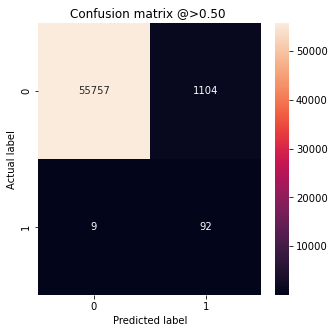

In [63]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

plot_cm(y_test, predictions_weighted, threshold=0.5)

## Plot the ROC

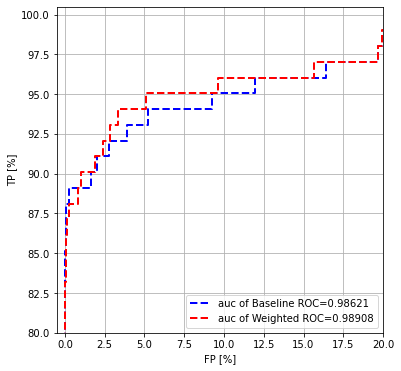

In [64]:
plot_roc("Baseline ROC", y_test, predictions_baseline, color='blue', linestyle='--')

plot_roc("Weighted ROC", y_test, predictions_weighted, color='red', linestyle='--')

plt.legend(loc='lower right')